In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.optimize as opt
import scipy as sci
import random
import matplotlib.pyplot as plt
from autograd import grad, jacobian
import sys
import torch
sys.path.append("../")
from ddn.basic.learnable_robust_nodes import LearnableRobustAverage
from ddn.basic.learnable_robust_nodes_new import LearnableRobustAverageNew
from ddn.basic.robust_nodes import RobustAverage

In [2]:
def f(x, y, alpha,p='pseudo-huber'):
    alpha_sq=alpha**2
    if p=='pseudo-huber':
        phi= lambda z: (alpha**2) * (np.sqrt(1.0 + np.power(z, 2.0) / (alpha**2)) - 1.0)
    elif p=='huber':
        phi = lambda z: np.where(np.abs(z) <= alpha, 0.5 * np.power(z, 2.0), alpha * np.abs(z) - 0.5 * alpha_sq)
    elif p=='welsch':
        phi = lambda z: 1.0 - np.exp(-0.5 * np.power(z, 2.0) / alpha_sq)
    elif p=='trunc-quad':
        phi = lambda z: np.minimum(0.5 * np.power(z, 2.0), 0.5 * alpha_sq)
    return np.sum([phi(y - xi) for xi in x])

# the solve objective function from ddn.basic.node
def solve(x,alpha ,f, p='pseudo-huber'):
    result = opt.minimize(lambda y : f(x, y, alpha,p), np.mean(x))
    return result.x
def dyalpha_closed_form(x,y,alpha,p='pseudo-huber'):
    alpha_sq=alpha**2
    if p=='pseudo-huber':
        dyy = np.array([np.power(1.0 + np.power(y - xi, 2.0) / alpha_sq, -1.5) for xi in x])
        dytheta =  np.sum([np.power(y-xi,3)/(np.power(np.power((y-xi)/alpha,2)+1,1.5)*np.power(alpha,3)) for xi in x])
    elif p=='huber':
        dyy = np.array([1.0 if np.abs(y - xi) <= alpha else 0.0 for xi in x])
        dytheta = np.sum(np.array([0.0 if np.abs(y - xi) <= alpha else (1.0 if y-xi>0 else -1.0) for xi in x]))
    elif p=='welsch':
        z = np.power(x - y, 2.0)
        dyy = np.array([(alpha_sq - zi) / (alpha_sq * alpha_sq) * np.exp(-0.5 * zi / alpha_sq) for zi in z])
        dytheta=np.sum(np.array([-np.exp(-0.5 * np.power((y - xi)/alpha,2))*((2*(y-xi)*alpha_sq-np.power(y-xi,3))/(alpha**5)) for xi in x])) 
    elif p=='trunc-quad':
        return 0
    return -1.0 * dytheta/np.sum(dyy)

In [3]:
def lbfgs(node, y_target, max_iters=1000,x_init=None, theta_init=None, verbose=True, train_x=False):
    """
    Example of using scipy.optimize to solve the problem via L-BFGS.
    """
    theta_start = theta_init if theta_init is not None else 1.0
    x_start = (x_init.clone() if type(x_init)==torch.Tensor else x_init.copy()) if x_init is not None else 1.0
    if train_x:
        para= torch.cat((x_start,torch.tensor([theta_start]))) if type(x_start)==torch.tensor else np.concatenate((x_start, np.array([theta_start])), axis=0)
    else:
        para= theta_start
    def J(para):
        if train_x:
            x= para[:-1]
            theta=para[-1]
        else:
            x=x_init
            theta=para
        if type(node)==LearnableRobustAverageNew:
            y, _ = node.solve(x, theta)
            return 0.5 * np.sum(np.square(y - y_target))
        else:
            x=torch.tensor(x)
            theta=torch.tensor(theta)
            y, _ = node.project(x, theta)
            return  0.5 * ((y - y_target)**2).sum()
    def dJdtheta(para):
        if train_x:
            x= para[:-1]
            theta=para[-1]
        else:
            x=x_init
            theta=para
        if type(node)==LearnableRobustAverageNew:
            y, _ = node.solve(x, theta)
            dx,dr= node.gradient(x, y, theta)
            DJdx=np.dot(y - y_target,dx).reshape((node.dim_x,))
            DJdr=(y - y_target)*dr
            if train_x:
                return np.concatenate((DJdx,DJdr),axis=0)
            else:
                return DJdr
        else:
            x=torch.tensor(x)
            theta=torch.tensor(theta)
            y, is_outside = node.project(x, theta)
            DJdx, DJdtheta = node.gradient((y - y_target),x, y,is_outside)
            if train_x:
                return torch.cat((DJdx,torch.tensor([DJdtheta])))
            else:
                return torch.tensor([DJdtheta])
    history = [J(para)]
    thetas=[theta_start]
    if type(node)==LearnableRobustAverageNew:
        ys=[node.solve(x_start, theta_start)]
    else:
        ys=[node.project(x_start, theta_start)]
    def callback(para):
        if train_x:
            x= para[:-1]
            theta=para[-1]
        else:
            x=x_init
            theta=para
        thetas.append(theta)
        history.append(J(para))
        if type(node)==LearnableRobustAverageNew:
            ys.append(node.solve(x, theta))
        else:
            x=torch.tensor(x)
            theta=torch.tensor(theta)
            ys.append(node.project(x, theta))
    opts = {'maxiter': max_iters, 'disp': verbose}
    result = opt.minimize(J, para, args=(), method='L-BFGS-B', jac=dJdtheta, options=opts, callback=callback)
    if train_x:
        x_final= result.x[:-1]
        theta_final= result.x[-1]
        if type(node)!=LearnableRobustAverageNew:
            x_final=torch.tensor(x_final)
            theta_final=torch.tensor([theta_final])
    else:
        x_final =x_init
        theta_final= result.x
    return theta_final, history,thetas,ys,x_final


def simpleGradientDescent(node, y_target, step_size=1.0e-3, tol=1.0e-7, max_iters=10000,x_init = None, theta_init=None, verbose=False,train_x=False):
    theta = theta_init if theta_init is not None else 0
    if type(node)==LearnableRobustAverageNew:
        x = x_init.copy()
        J = lambda y : 0.5 * np.sum(np.square(y - y_target))
    else:
        x = x_init.clone()
        J = lambda y : 0.5 * ((y - y_target)**2).sum()
    dJdy = lambda y : y - y_target
    history = []
    thetas=[]
    ys=[]
    for i in range(max_iters):
        # solve the lower-level problem and compute the upper-level objective
        if type(node)==LearnableRobustAverageNew:
            y, _ = node.solve(x,theta)
        else:
            y, is_outside = node.project(x,theta)
        history.append(J(y))
        if verbose: print("{:5d}: {}".format(i, history[-1]))
        if (len(history) > 2) and (history[-2] - history[-1]) < tol:
            break
        # compute the gradient of the upper-level objective with respect to x via the chain rule
        if type(node)==LearnableRobustAverageNew:
            dydx,dydtheta= node.gradient(x, y,theta)
            dJdx = np.dot(dJdy(y), dydx)
            dJdtheta = np.dot(dJdy(y), dydtheta)
        else:
            dJdx,dJdtheta = node.gradient(dJdy(y),x,y,is_outside)
        # take a step in the negative gradient direction
        theta -= step_size * dJdtheta
        if train_x:
            x -= step_size * dJdx
        if type(node)==LearnableRobustAverageNew:
            thetas.append(theta.copy())
        else:
            thetas.append(theta.clone())
        ys.append(y)
    return theta, history,thetas,ys,x

In [4]:
np.random.seed(1123)
x_init=np.random.rand(50)
idx= np.random.choice(50, 10)
x_true=x_init.copy()
x_init[idx] += x_init[idx]*10
alpha_init=np.random.randint(5,10)
p='huber'

In [5]:
# node = LearnableRobustAverageNew(50, penalty=p, alpha=alpha_init)
# y_target=x_true.mean()
# y_init,_=node.solve(x_init,alpha_init)
# print(y_init,y_target,node.solve(x_init,0.4))
# # alpha_gd1, history1,alphas1,ys1,x_final1 = lbfgs(node, y_target,max_iters=1000,x_init=x_init,theta_init=alpha_init, train_x=train_x)
# # print(alphas1)
# alpha_gd2, history2,alphas2,ys2,x_final2 = simpleGradientDescent(node, y_target,x_init=x_init, theta_init=alpha_init,step_size=0.25, train_x=False)
# #print(alphas2)

In [6]:
# plt.plot(alphas2)
# y_final,_=node.solve(x_init,alphas2[-1])
# print(y_final,y_target,x_init.mean())
# print(alpha_init,alphas2[-1])

([], [])

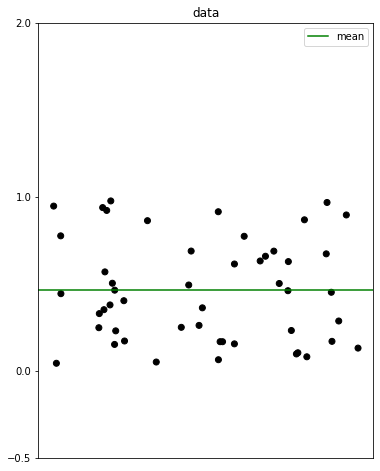

In [7]:
np.random.seed(527)
N = 50
#idx= np.random.choice(50, 10)
colors=np.array(['black' for i in range(50)])
#print(y[idx])
x = np.random.rand(N)
y = np.random.rand(N)
y_mean=y.mean()
#print(y)
#y[idx]=y[idx]*5
#print(y)
plt.figure(figsize=(6,8))
plt.subplot(111)
plt.title('data')
plt.scatter(x, y,c=colors)
#plt.axhline(y=1.0, color='black', linestyle=':',label='bound')
plt.axhline(y=y_mean, color='green', linestyle='-',label='mean')
#plt.axhline(y=0.0, color='black', linestyle=':')
plt.legend()
plt.yticks([-0.5, 0.0, 1.0, 2.0])
plt.xticks([])

1.2542456370413413 2.2288782581214432


([], [])

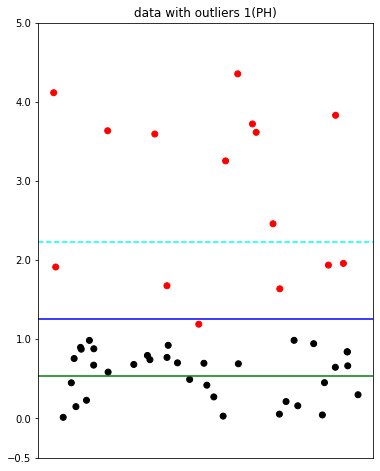

In [8]:
np.random.seed(527)
N = 50
idx= np.random.choice(50, 20)
#print(y[idx])
colors=np.array(['black' for i in range(50)])
x = np.random.rand(N)
y_init = np.random.rand(N)
y=y_init.copy()
y[idx]=y[idx]*4+1
colors[idx]='r'
y_mean=y.mean()
alpha_init=np.random.rand()*3+2
print(y_mean,alpha_init)
#print(y)
plt.figure(figsize=(6,8))
plt.figure(1)
plt.subplot(111)
plt.title('data with outliers 1(PH)')
plt.scatter(x, y,c=colors)
#plt.axhline(y=1.0, color='black', linestyle=':',label='bound')
plt.axhline(y=y_mean, color='b', linestyle='-',label='robust mean(PH)')
plt.axhline(y=y_init.mean(), color='green', linestyle='-',label='mean(no outliers)')
plt.axhline(y=alpha_init, color='cyan', linestyle='--',label='threshold(c)')
#plt.axhline(y=0.0, color='black', linestyle=':')
plt.yticks([-0.5, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
#plt.legend()
#plt.legend()
plt.xticks([])

In [9]:
node = LearnableRobustAverageNew(50, penalty='pseudo-huber', alpha=alpha_init)
y_target=y_init.mean()
y_mean_init,_=node.solve(y,alpha_init)
#print(y_init,y_target,node.solve(x_init,0.4))
# alpha_gd1, history1,alphas1,ys1,x_final1 = lbfgs(node, y_target,max_iters=1000,x_init=x_init,theta_init=alpha_init, train_x=train_x)
# print(alphas1)
alpha_gd2, history2,alphas2,ys2,x_final2 = simpleGradientDescent(node, y_target,x_init=y, theta_init=alpha_init,step_size=0.25, train_x=False)
y_mean_learned=node.solve(y_init,alphas2[-1])[0][0]

In [10]:
print(alphas2[-1])
#y_mean_learned=node.solve(y_init,alphas2[-1])[0][0]
print(y_mean_learned)

[-1.60535942]
0.5372531753381605


1.2542456370413413 2.2288782581214432


([], [])

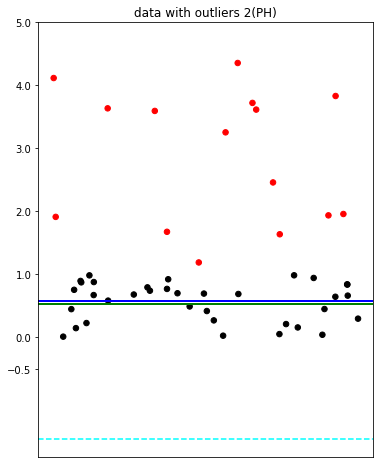

In [11]:
np.random.seed(527)
N = 50
idx= np.random.choice(50, 20)
#print(y[idx])
colors=np.array(['black' for i in range(50)])
x = np.random.rand(N)
y_init = np.random.rand(N)
y=y_init.copy()
y[idx]=y[idx]*4+1
colors[idx]='r'
y_mean=y.mean()
alpha_init=np.random.rand()*3+2
print(y_mean,alpha_init)
#print(y)
plt.figure(figsize=(6,8))
plt.figure(1)
plt.subplot(111)
plt.title('data with outliers 2(PH)')
plt.scatter(x, y,c=colors,s=30)
#plt.axhline(y=1.0, color='black', linestyle=':',label='bound')
plt.axhline(y=y_mean_learned+0.04, color='blue', linestyle='-',label='robust mean(PH)',linewidth =2)
plt.axhline(y=y_target, color='green', linestyle='-',label='mean (no outliers)',linewidth =2)
#plt.axhline(y=y_mean, color='b', linestyle='-',label='init mean')
#plt.axhline(y=alpha_init, color='g', linestyle='--',label='initial threshold(c)')
plt.axhline(y=alphas2[-1], color='cyan', linestyle='--',label='threshold(c)')
#plt.axhline(y=0.0, color='black', linestyle=':')
plt.yticks([-0.5, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
#plt.legend()
plt.xticks([])